In [8]:

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler


file_path = 'Customer_Churn_Data_Large.xlsx'
xls = pd.ExcelFile(file_path)

#Loading all sheets
df_demo = pd.read_excel(xls, 'Customer_Demographics')
df_trans = pd.read_excel(xls, 'Transaction_History')
df_service = pd.read_excel(xls, 'Customer_Service')
df_online = pd.read_excel(xls, 'Online_Activity')
df_churn = pd.read_excel(xls, 'Churn_Status')

#Feature Engineering & Aggregation

#Transactions
trans_agg = df_trans.groupby('CustomerID').agg({
    'AmountSpent': ['sum', 'mean', 'count'],
    'ProductCategory': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()
trans_agg.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'NumTransactions', 'TopCategory']

#Customer Service
service_agg = df_service.groupby('CustomerID').agg({
    'InteractionID': 'count',
    'InteractionType': lambda x: (x == 'Complaint').sum(),
    'ResolutionStatus': lambda x: (x == 'Unresolved').sum()
}).reset_index()
service_agg.columns = ['CustomerID', 'TotalInteractions', 'NumComplaints', 'Unresolved']

#Online Activity
df_online['DaysSinceLastLogin'] = (pd.to_datetime('today') - pd.to_datetime(df_online['LastLoginDate'])).dt.days
df_online.drop(columns='LastLoginDate', inplace=True)

#Mergeing tables
df_full = (
    df_demo
    .merge(trans_agg, on='CustomerID', how='left')
    .merge(service_agg, on='CustomerID', how='left')
    .merge(df_online, on='CustomerID', how='left')
    .merge(df_churn, on='CustomerID', how='left')
)

#Handle Missing Values

# Impute numerical columns with median
num_cols = df_full.select_dtypes(include=['int64', 'float64']).columns.drop('CustomerID')
df_full[num_cols] = df_full[num_cols].fillna(df_full[num_cols].median())

# Impute categorical columns with mode
cat_cols = df_full.select_dtypes(include='object').columns
df_full[cat_cols] = df_full[cat_cols].fillna(df_full[cat_cols].mode().iloc[0])

#Outlier Detection & Capping using IQR
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)

outlier_cols = ['TotalSpend', 'AvgSpend', 'NumTransactions', 'NumComplaints', 'Unresolved']
for col in outlier_cols:
    cap_outliers(df_full, col)

# Standardize Numeric Features
scale_cols = ['Age', 'TotalSpend', 'AvgSpend', 'NumTransactions',
              'TotalInteractions', 'NumComplaints', 'Unresolved',
              'LoginFrequency', 'DaysSinceLastLogin']

scaler = StandardScaler()
df_full[scale_cols] = scaler.fit_transform(df_full[scale_cols])

#One-Hot Encoding of Categorical Variables
categorical_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'TopCategory', 'ServiceUsage']
df_encoded = pd.get_dummies(df_full, columns=categorical_cols, drop_first=True)

#Final Preprocessed Data
df_encoded.head()


,CustomerID,Age,TotalSpend,AvgSpend,NumTransactions,TotalInteractions,NumComplaints,Unresolved,LoginFrequency,DaysSinceLastLogin,...,MaritalStatus_Single,MaritalStatus_Widowed,IncomeLevel_Low,IncomeLevel_Medium,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Furniture,TopCategory_Groceries,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,1.229628,-1.152196,2.208707,-1.557954,-1.223522,-0.612876,-1.507865,0.575702,-1.021557,...,True,False,True,False,False,True,False,False,False,False
1,2,1.426547,0.379758,-0.366398,0.747849,-1.223522,-0.612876,-1.507865,-1.488513,-1.450763,...,False,False,True,False,False,True,False,False,False,True
2,3,-1.658518,0.590481,0.460655,0.363548,-1.223522,-0.612876,-1.507865,-1.630872,-1.260005,...,True,False,True,False,False,False,True,False,False,True
3,4,-1.461599,-0.473822,-0.861840,-0.020752,1.223522,-0.612876,0.351401,-1.702052,-0.477897,...,False,True,True,False,False,True,False,False,False,True
4,5,-1.461599,0.994845,0.017367,1.132149,0.000000,-0.612876,0.351401,1.073961,-1.078785,...,False,False,False,True,False,True,False,False,False,True


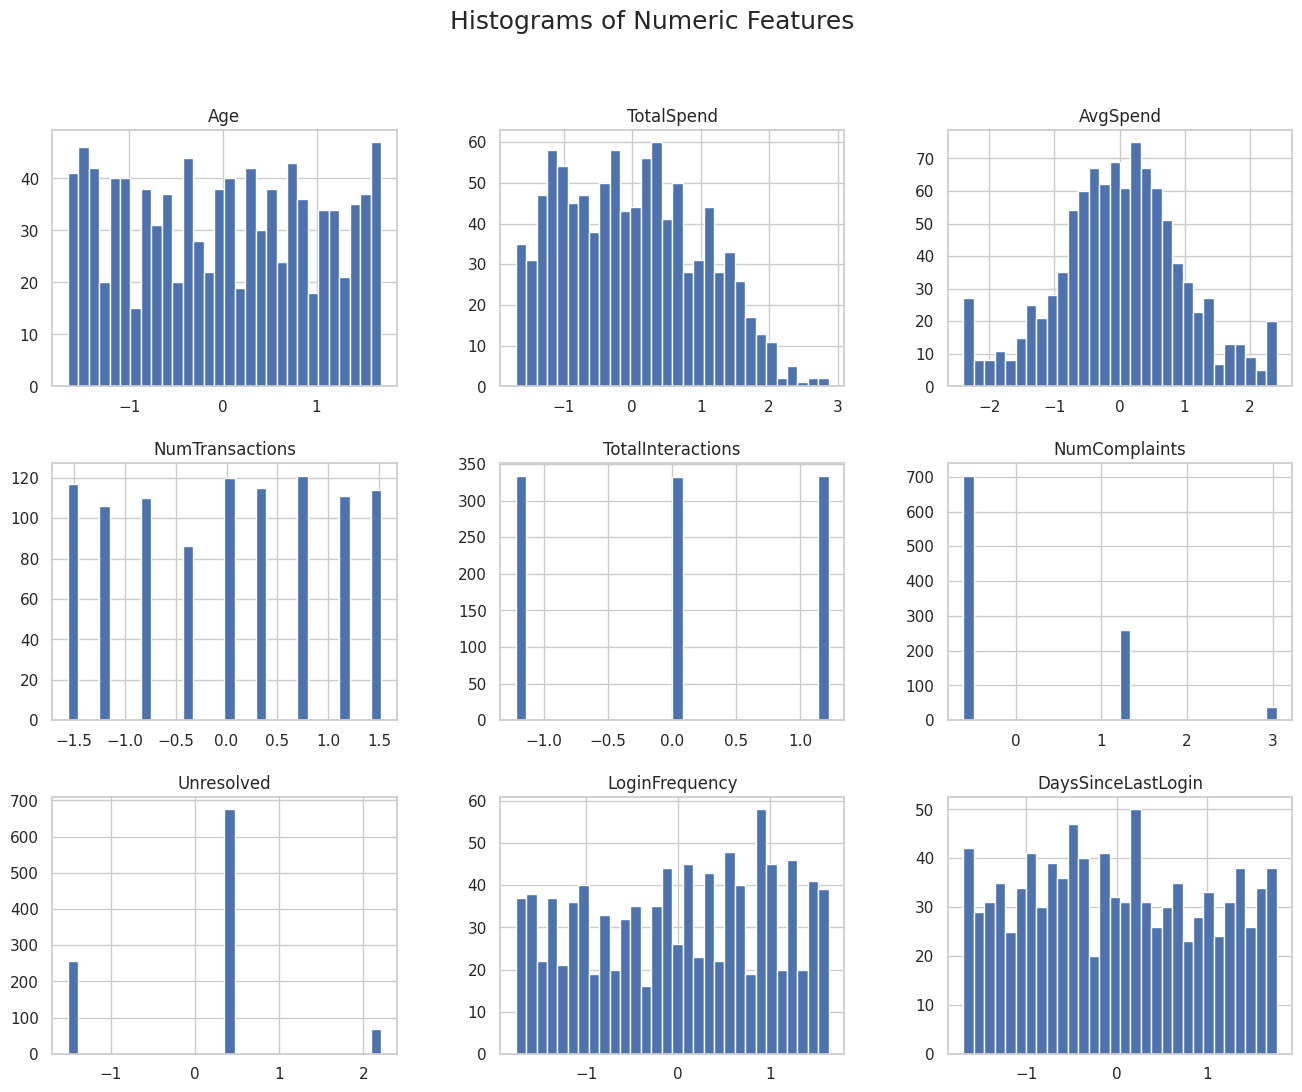

In [9]:
numeric_cols = ['Age', 'TotalSpend', 'AvgSpend', 'NumTransactions',
                'TotalInteractions', 'NumComplaints', 'Unresolved',
                'LoginFrequency', 'DaysSinceLastLogin']

df_full[numeric_cols].hist(figsize=(16, 12), bins=30)
plt.suptitle("Histograms of Numeric Features", fontsize=18)
plt.show()

/tmp/ipython-input-10-409634077.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=income_churn, x='IncomeLevel', y='ChurnRate',


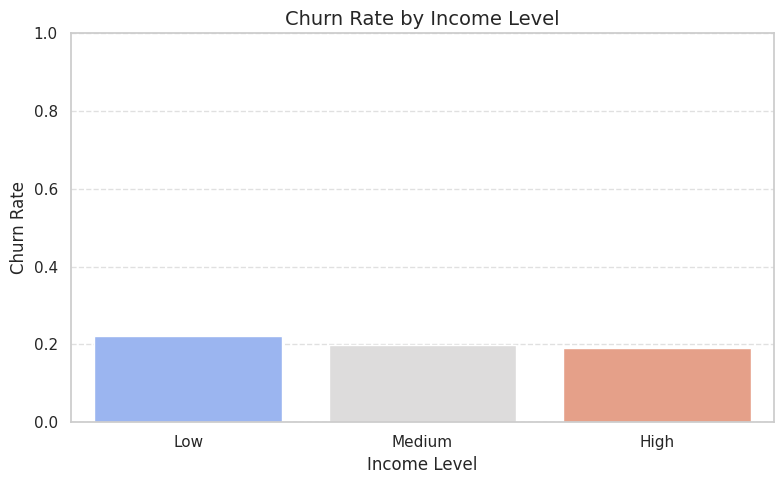

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure ChurnStatus is numeric (if not already)
df_full['ChurnStatus'] = pd.to_numeric(df_full['ChurnStatus'], errors='coerce')

# Calculate churn rate per income level
income_churn = df_full.groupby('IncomeLevel')['ChurnStatus'].mean().reset_index()
income_churn.columns = ['IncomeLevel', 'ChurnRate']

# Plotting
plt.figure(figsize=(8,5))
sns.barplot(data=income_churn, x='IncomeLevel', y='ChurnRate',
            order=['Low', 'Medium', 'High'], palette='coolwarm')

plt.title('Churn Rate by Income Level', fontsize=14)
plt.ylabel('Churn Rate')
plt.xlabel('Income Level')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipython-input-11-3131570186.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unresolved_churn, x='HasUnresolvedComplaint', y='ChurnRate', palette='mako')


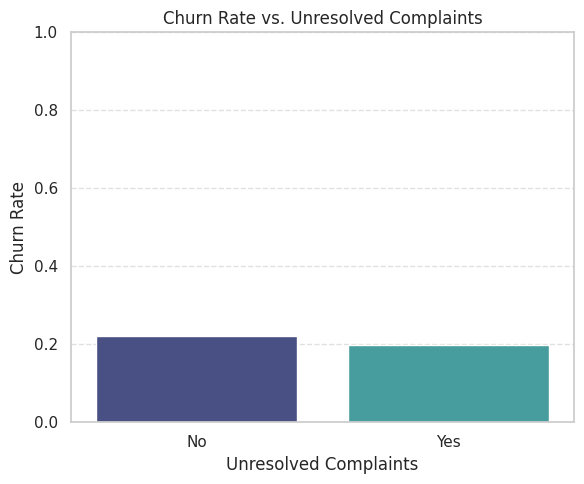

In [11]:
# Create a binary column: Has unresolved complaint (1 if unresolved complaints > 0)
df_full['HasUnresolvedComplaint'] = df_full['Unresolved'] > 0

# Group by unresolved complaints and calculate churn rate
unresolved_churn = df_full.groupby('HasUnresolvedComplaint')['ChurnStatus'].mean().reset_index()
unresolved_churn['HasUnresolvedComplaint'] = unresolved_churn['HasUnresolvedComplaint'].map({True: 'Yes', False: 'No'})
unresolved_churn.columns = ['HasUnresolvedComplaint', 'ChurnRate']

# Plot
plt.figure(figsize=(6,5))
sns.barplot(data=unresolved_churn, x='HasUnresolvedComplaint', y='ChurnRate', palette='mako')
plt.title('Churn Rate vs. Unresolved Complaints')
plt.ylabel('Churn Rate')
plt.xlabel('Unresolved Complaints')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [12]:
df_encoded.to_csv("cleaned_churn_dataset.csv", index=False)
